This code is useful in data loading, visualization and exploration. You are free to modify the code. The code has dependecy on Pytorch Lightning data module. However, you may use Pytorch as well.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

**Introduction to Dataset**

The data has a total of 10 classes with 40 samples each. Make sure while working with the data, **esc10=True**. In the assignment, you are required to perform 4-fold validation. This dataset has been already divided into 5-folds. The column 'fold' in the metafile denotes the sample in a particular fold. Moreover, first folds is considered for test, rest for 4-fold validation.

In [2]:
# DL Assignment 2
# Authors: Kopal Rastogi, Ishan Mishra
# Keywords: None
# Assumptions: None

In [3]:
# # Installing the requirements
# print('Installing Requirements... ',end='')
# !pip install lightning
# !pip install wandb
# print('Done')

In [4]:
# Importing Libraries
print('Importing Libraries... ',end='')
import os
from pathlib import Path
import pandas as pd
import torchaudio
import zipfile
from torchaudio.transforms import Resample
import IPython.display as ipd
from matplotlib import pyplot as plt
from tqdm import tqdm
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import torch
print('Done')

Importing Libraries... 

c:\Users\Manish\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Done


In [5]:
# Download data
print('Downlading data... ', end='')
# Your code here
print('Done')

Downlading data... Done


In [6]:
# Extract data
with zipfile.ZipFile(r"C:\Users\Manish\Desktop\Assignment2\Archive.zip", 'r') as zip_ref:
    zip_ref.extractall(r"C:\Users\Manish\Desktop\Assignment2")

# Loading dataset
path = Path(r'C:\Users\Manish\Desktop\Assignment2')
df = pd.read_csv(r'C:\Users\Manish\Desktop\Assignment2\meta\esc50.csv')

Shape of waveform: torch.Size([1, 220500])
Sample rate of waveform: 44100


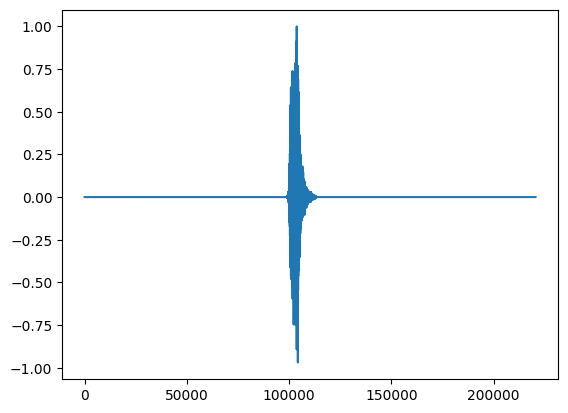

In [7]:
# Getting list of raw audio files
wavs = list(path.glob('audio/*'))  # List all audio files in the 'audio' directory using pathlib.Path.glob

# Visualizing data
waveform, sample_rate = torchaudio.load(wavs[0])  # Load the waveform and sample rate of the first audio file using torchaudio

print("Shape of waveform: {}".format(waveform.size()))  # Print the shape of the waveform tensor
print("Sample rate of waveform: {}".format(sample_rate))  # Print the sample rate of the audio file

# Plot the waveform using matplotlib
plt.figure()
plt.plot(waveform.t().numpy())  # Transpose and convert the waveform tensor to a NumPy array for plotting

# Display the audio using IPython.display.Audio
ipd.Audio(waveform, rate=sample_rate)  # Create an interactive audio player for the loaded waveform


In [8]:
class CustomDataset(Dataset):
    def __init__(self, dataset, **kwargs):
        # Initialize CustomDataset object with relevant parameters
        # dataset: "train", "val", or "test"
        # kwargs: Additional parameters like data directory, dataframe, folds, etc.

        # Extract parameters from kwargs
        self.data_directory = kwargs["data_directory"]
        self.data_frame = kwargs["data_frame"]
        self.validation_fold = kwargs["validation_fold"]
        self.testing_fold = kwargs["testing_fold"]
        self.esc_10_flag = kwargs["esc_10_flag"]
        self.file_column = kwargs["file_column"]
        self.label_column = kwargs["label_column"]
        self.sampling_rate = kwargs["sampling_rate"]
        self.new_sampling_rate = kwargs["new_sampling_rate"]
        self.sample_length_seconds = kwargs["sample_length_seconds"]

        # Filter dataframe based on esc_10_flag and data_type
        if self.esc_10_flag:
            self.data_frame = self.data_frame.loc[self.data_frame['esc10'] == True]

        if dataset == "train":
            self.data_frame = self.data_frame.loc[
                (self.data_frame['fold'] != self.validation_fold) & (self.data_frame['fold'] != self.testing_fold)]
        elif dataset == "val":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.validation_fold]
        elif dataset == "test":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.testing_fold]

        # Get unique categories from the filtered dataframe
        self.categories = sorted(self.data_frame[self.label_column].unique())

        # Initialize lists to hold file names, labels, and folder numbers
        self.file_names = []
        self.labels = []

        # Initialize dictionaries for category-to-index and index-to-category mapping
        self.category_to_index = {}
        self.index_to_category = {}

        for i, category in enumerate(self.categories):
            self.category_to_index[category] = i
            self.index_to_category[i] = category

        # Populate file names and labels lists by iterating through the dataframe
        for ind in tqdm(range(len(self.data_frame))):
            row = self.data_frame.iloc[ind]
            file_path = self.data_directory / "audio" / row[self.file_column]
            self.file_names.append(file_path)
            self.labels.append(self.category_to_index[row[self.label_column]])

        self.resampler = torchaudio.transforms.Resample(self.sampling_rate, self.new_sampling_rate)

        # Window size for rolling window sample splits (unfold method)
        if self.sample_length_seconds == 2:
            self.window_size = self.new_sampling_rate * 2
            self.step_size = int(self.new_sampling_rate * 0.75)
        else:
            self.window_size = self.new_sampling_rate
            self.step_size = int(self.new_sampling_rate * 0.5)

    def __getitem__(self, index):
        # Split audio files with overlap, pass as stacked tensors tensor with a single label
        path = self.file_names[index]
        audio_file = torchaudio.load(path, format=None, normalize=True)
        audio_tensor = self.resampler(audio_file[0])
        splits = audio_tensor.unfold(1, self.window_size, self.step_size)
        samples = splits.permute(1, 0, 2)
        return samples, self.labels[index]

    def __len__(self):
        return len(self.file_names)


In [9]:
class CustomDataModule(pl.LightningDataModule):
    def __init__(self, **kwargs):
        # Initialize the CustomDataModule with batch size, number of workers, and other parameters
        super().__init__()
        self.batch_size = kwargs["batch_size"]
        self.num_workers = kwargs["num_workers"]
        self.data_module_kwargs = kwargs

    def setup(self, stage=None):
        # Define datasets for training, validation, and testing during Lightning setup

        # If in 'fit' or None stage, create training and validation datasets
        if stage == 'fit' or stage is None:
            self.training_dataset = CustomDataset(dataset="train", **self.data_module_kwargs)
            self.validation_dataset = CustomDataset(dataset="val", **self.data_module_kwargs)

        # If in 'test' or None stage, create testing dataset
        if stage == 'test' or stage is None:
            self.testing_dataset = CustomDataset(dataset="test", **self.data_module_kwargs)

    def train_dataloader(self):
        # Return DataLoader for training dataset
        return DataLoader(self.training_dataset,
                          batch_size=self.batch_size,
                          shuffle=True,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        # Return DataLoader for validation dataset
        return DataLoader(self.validation_dataset,
                          batch_size=self.batch_size,
                          shuffle=False,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def test_dataloader(self):
        # Return DataLoader for testing dataset
        return DataLoader(self.testing_dataset,
                          batch_size=32,
                          shuffle=False,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def collate_function(self, data):
        """
        Collate function to process a batch of examples and labels.

        Args:
            data: a tuple of 2 tuples with (example, label) where
                example are the split 1 second sub-frame audio tensors per file
                label = the label

        Returns:
            A list containing examples (concatenated tensors) and labels (flattened tensor).
        """
        examples, labels = zip(*data)
        # examples = torch.cat(examples)
        examples = torch.stack(examples)
        examples = examples.reshape(examples.size(0),1,-1)
        labels = torch.flatten(torch.tensor(labels))

        return [examples, labels]


In [10]:
# Data Setup
test_samp = 1 #Do not change this!!
valid_samp = 2 # Use any value ranging from 2 to 5 for k-fold validation (valid_fold)
batch_size = 32 # Free to change
num_workers = 0 # Free to change
custom_data_module = CustomDataModule(batch_size=batch_size,
                                      num_workers=num_workers,
                                      data_directory=path,
                                      data_frame=df,
                                      validation_fold=valid_samp,
                                      testing_fold=test_samp,  # set to 0 for no test set
                                      esc_10_flag=True,
                                      file_column='filename',
                                      label_column='category',
                                      sampling_rate=44100,
                                      new_sampling_rate=16000,  # new sample rate for input
                                      sample_length_seconds=1  # new length of input in seconds
                                      )

custom_data_module.setup()


100%|██████████| 80/80 [00:00<00:00, 3702.03it/s]


In [11]:
# Data Exploration
print('Class Label: ', custom_data_module.training_dataset[0][1])  # this prints the class label
print('Shape of data sample tensor: ', custom_data_module.training_dataset[0][0].shape)  # this prints the shape of the sample (Frames, Channel, Features)


Class Label:  2
Shape of data sample tensor:  torch.Size([9, 1, 16000])


In [12]:
# Dataloader(s)
x = next(iter(custom_data_module.train_dataloader()))
y = next(iter(custom_data_module.val_dataloader()))
z = next(iter(custom_data_module.test_dataloader()))
print('Train Dataloader:')
print(x)
print('Validation Dataloader:')
print(y)
print('Test Dataloader:')
print(z)


Train Dataloader:
[tensor([[[-3.2051e-04, -7.2169e-04, -1.0532e-03,  ..., -1.4167e-03,
          -1.9971e-03, -2.0960e-03]],

        [[ 8.0511e-04,  1.2498e-03,  1.3721e-03,  ...,  3.4916e-02,
           3.2299e-02,  3.5322e-02]],

        [[ 2.0278e-05,  2.1389e-05,  1.3558e-05,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        ...,

        [[ 5.9981e-05, -3.4401e-05, -1.6934e-04,  ..., -2.2356e-02,
          -2.2097e-02, -2.4475e-02]],

        [[ 4.2543e-04,  1.1862e-03,  9.4927e-04,  ..., -2.8716e-03,
          -2.8779e-03, -2.6803e-03]],

        [[-7.1939e-03, -1.1770e-02, -9.8855e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]]]), tensor([1, 1, 4, 5, 3, 7, 9, 3, 2, 4, 9, 6, 9, 8, 8, 7, 2, 5, 7, 3, 4, 6, 8, 6,
        7, 6, 0, 4, 4, 2, 1, 3])]
Validation Dataloader:
[tensor([[[-4.1812e-05, -9.4571e-05, -2.7154e-04,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[-9.2098e-02, -2.8477e-02,  1.7923e-02,  ...,  9.4242e-02,
           

In [13]:
x[0].size()

torch.Size([32, 1, 144000])

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
import wandb

import torchvision
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [15]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print("Device:", device)

In [16]:
# class Architecture(nn.Module):
#     def __init__(self):
#         super(Architecture, self).__init__()
#         self.conv1 = nn.Conv1d(1, 32, kernel_size=7, stride=1, padding=3)
#         self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
#         self.conv3 = nn.Conv1d(64, 32, kernel_size=3, stride=1, padding=1)
#         self.fc = nn.Linear(576000, 10)

#     def forward(self, x):
#         x = F.max_pool1d(F.relu(self.conv1(x)), 2)
#         x = F.max_pool1d(F.relu(self.conv2(x)), 2)
#         x = F.max_ppol1d(F.relu(self.conv3(x)), 2)
#         x = x.view(x.size(0), -1)
#         x = F.softmax(self.fc(x), dim=1)
#         return x

In [17]:
class Architecture(nn.Module):
    def __init__(self):
        super(Architecture, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(16)  # BatchNorm1d after first conv layer
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(32)  # BatchNorm1d after second conv layer
        self.conv3 = nn.Conv1d(32, 48, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(48)  # BatchNorm1d after third conv layer
        self.conv4 = nn.Conv1d(48, 32, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(32)
        self.conv5 = nn.Conv1d(32, 16, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm1d(16)
        self.fc1 = nn.Linear(72000, 10)
        # self.fc2 = nn.Linear(36000, 10)
        # self.fc3 = nn.Linear(2250, 10)

    def forward(self, x):
        x = F.max_pool1d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool1d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool1d(F.relu(self.bn3(self.conv3(x))), 2)
        x = F.max_pool1d(F.relu(self.bn4(self.conv4(x))), 2)
        x = F.max_pool1d(F.relu(self.bn5(self.conv5(x))), 2)
        x = x.view(x.size(0), -1)
        # x = F.relu(self.fc1(x))  # Add ReLU after fc1
        # x = F.relu(self.fc2(x))  # Add ReLU after fc2
        x = F.softmax(self.fc1(x), dim=1)  # Apply softmax on final layer
        return x



In [18]:
# Hyperparameters
input_size = x[0][0].shape[1]
num_classes = 10
lr = 0.001
epochs = 10

In [19]:
# # WandB initialization
# wandb.init(project="your_project_name", entity="your_entity_name")
# config = wandb.config
# config.learning_rate = lr
# config.batch_size = batch_size
# config.epochs = epochs

In [20]:
# Model, Optimizer, Loss function
# model = Architecture().to(device)
model = Architecture()
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [21]:
print(x[0][0].shape)

torch.Size([1, 144000])


In [22]:
# # Get features and labels
# X = [sample[0] for sample in custom_data_module.training_dataset]
# Y = [sample[1] for sample in custom_data_module.training_dataset]

# print(X[0].shape, Y[0])

In [23]:
custom_data_module.train_dataloader()

In [24]:
# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in custom_data_module.train_dataloader():
        # data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)

        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    train_loss = running_loss / len(custom_data_module.train_dataloader())
    train_acc = 100. * correct / total
    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Training Accuracy: {train_acc}')

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data, target in custom_data_module.test_dataloader():
            # data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
            _, predicted = output.max(1)

            val_total += target.size(0)
            val_correct += predicted.eq(target).sum().item()

    val_loss /= len(custom_data_module.test_dataloader())
    val_acc = 100. * val_correct / val_total

    print(f'Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

    # # Logging
    # wandb.log({"Train Loss": train_loss, "Train Acc": train_acc, "Val Loss": val_loss, "Val Acc": val_acc})
    # print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
    #       f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')


Epoch 1/10, Training Loss: 2.275064080953598, Training Accuracy: 15.833333333333334
Epoch 1/10, Validation Loss: 2.3562750021616616, Validation Accuracy: 10.0
Epoch 2/10, Training Loss: 2.251421093940735, Training Accuracy: 21.666666666666668
Epoch 2/10, Validation Loss: 2.3569839000701904, Validation Accuracy: 10.0
Epoch 3/10, Training Loss: 2.249753028154373, Training Accuracy: 21.666666666666668
Epoch 3/10, Validation Loss: 2.3569839000701904, Validation Accuracy: 10.0
Epoch 4/10, Training Loss: 2.2298625111579895, Training Accuracy: 22.083333333333332
Epoch 4/10, Validation Loss: 2.3566226164499917, Validation Accuracy: 10.0


KeyboardInterrupt: 

In [ ]:
# Testing
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for data, target in custom_data_module.test_dataloader():
        output = model(data)
        _, predicted = output.max(1)
        test_total += target.size(0)
        test_correct += predicted.eq(target).sum().item()

test_acc = 100. * test_correct / test_total
# print(f'Test accuracy: {}')
# wandb.log({"Test Acc": test_acc})
print(f'Test Accuracy: {test_acc:.2f}%')

In [ ]:
# # Print evaluation metrics
# print(f'Test Accuracy: {test_acc:.2f}%')
# print('Confusion Matrix:')
# print(test_confusion)
# print('F1 Scores:')
# print(test_f1_scores)
# print(f'AUC-ROC Score: {test_auc_roc:.2f}')

# # Plot Confusion Matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(test_confusion, annot=True, cmap="Blues", fmt="d", xticklabels=[str(i) for i in range(num_classes)], yticklabels=[str(i) for i in range(num_classes)])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

# # Finish WandB run
# wandb.finish()

In [ ]:
class Architecture2(nn.Module):
    def __init__(self):
        super(Architecture2, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(16)  # BatchNorm1d after first conv layer
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(32)  # BatchNorm1d after second conv layer
        self.conv3 = nn.Conv1d(32, 48, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(48)  # BatchNorm1d after third conv layer
        self.conv4 = nn.Conv1d(48, 32, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(32)
        self.conv5 = nn.Conv1d(32, 16, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm1d(16)
        self.fc1 = nn.Linear(72000, 10)
        # self.fc2 = nn.Linear(36000, 10)
        # self.fc3 = nn.Linear(2250, 10)

    def forward(self, x):
        x = F.max_pool1d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool1d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool1d(F.relu(self.bn3(self.conv3(x))), 2)
        x = F.max_pool1d(F.relu(self.bn4(self.conv4(x))), 2)
        x = F.max_pool1d(F.relu(self.bn5(self.conv5(x))), 2)
        x = x.view(x.size(0), -1)
        # x = F.relu(self.fc1(x))  # Add ReLU after fc1
        # x = F.relu(self.fc2(x))  # Add ReLU after fc2
        x = F.softmax(self.fc1(x), dim=1)  # Apply softmax on final layer
        return x



In [ ]:
# Hyperparameters
input_size = x[0][0].shape[1]
num_classes = 10
lr = 0.001
epochs = 10

# Model, Optimizer, Loss function
model2 = Architecture2().to(device)
# model = Architecture()
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [ ]:
def transformer_encoder():
    #Positional encoding

    #Multi-head self attention

    #layer norm

    #mlp

    #layer norm


In [ ]:
def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P

P = getPositionEncoding(seq_len=72000, d=512, n=100)
print(P.shape)

In [ ]:
def multi_head_self_attention(x, embed_dim, n_heads, attn_mask=None):
    """
    Args:
        x: Input tensor of shape (seq_len, embed_dim).
        embed_dim: Embedding dimension.
        n_heads: Number of attention heads.
        attn_mask: Optional attention mask tensor of shape (seq_len, seq_len).

    Returns:
        output: Attention output tensor of shape (seq_len, embed_dim).
    """

    assert embed_dim % n_heads == 0  # Ensure divisibility
    head_dim = embed_dim // n_heads  # Key/query dimension per head

    # Linear projections for queries, keys, and values
    q, k, v = [torch.nn.Linear(embed_dim, embed_dim)(x).view(x.size(0), n_heads, head_dim) for _ in range(3)]

    # Scaled dot-product attention
    scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(head_dim)
    if attn_mask is not None:
        scores = scores.masked_fill(attn_mask == 0, -1e9)
    attn = torch.nn.functional.softmax(scores, dim=-1)
    output = torch.matmul(attn, v)

    # Combine heads and return output
    return output.view(x.size(0), head_dim * n_heads)


In [ ]:
import torch
import numpy as np

# Sample input tensor (replace with your actual data)
x = torch.randn(36000, 200)  # (batch_size, seq_len, embed_dim)

# Hyperparameters
embed_dim = 200
n_heads = 2

# Function call with no attention mask
output = multi_head_self_attention(x, embed_dim, n_heads)

# Print the output shape
print(output.shape)

# Optionally, print some sample values for verification
print(output[0, :10, :5])  # Print first 10 elements from the first batch, first 5 elements from each head
